In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler ,  StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
df_feat = pd.read_csv(r'C:\Users\NAGUI\Downloads\Projet PIE - Encrypted\Projet PIE - Encrypted\encoded data\opamps-features.csv')
df_ref = pd.read_csv(r'C:\Users\NAGUI\Downloads\Projet PIE - Encrypted\Projet PIE - Encrypted\encoded data\opamps-xref.csv')

# Prétraitement

In [3]:
categorical_columns = ["Supplier_Package","MANUFACTURER"]
numerical_columns = ["Maximum Input Offset Voltage","Maximum Single Supply Voltage","Minimum Single Supply Voltage","Number of Channels per Chip","Typical Gain Bandwidth Product"]

## Normalisation des données numériques

In [4]:
import helper_functions.preprocess as pp

df_feat_scaled , scaler = pp.scale(df_feat,numerical_columns)
df = pp.merge_datasets(df_feat_scaled,df_ref)

## Conversion de la Cross Reference Type en numerique

In [5]:
base_means = {'A': 0.95, 'B': 0.8, 'C': 0.65, 'D': 0.5}
base_std = {'A': 0.025 / 3, 'B': 0.025 / 2.5, 'C': 0.025 / 2, 'D': 0.025 / 1.5}

<Axes: xlabel='Closeness', ylabel='Density'>

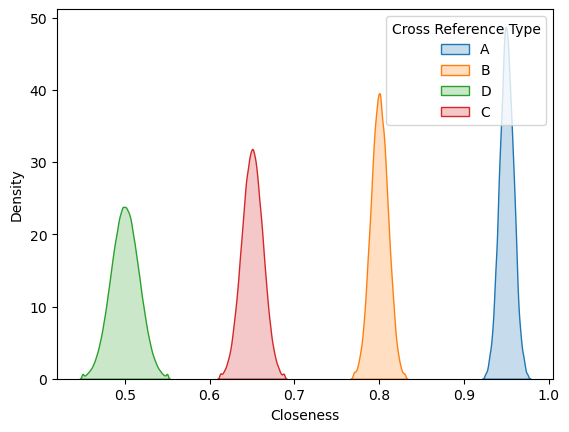

In [6]:
df = pp.generate_closeness(df,base_means,base_std,n_std=3)
sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [7]:
df

,Cross Reference Type,MPN,MANUFACTURER,Maximum Input Offset Voltage,Maximum Single Supply Voltage,Minimum Single Supply Voltage,Number of Channels per Chip,Supplier_Package,Typical Gain Bandwidth Product,MPN_comp,MANUFACTURER_comp,Maximum Input Offset Voltage_comp,Maximum Single Supply Voltage_comp,Minimum Single Supply Voltage_comp,Number of Channels per Chip_comp,Supplier_Package_comp,Typical Gain Bandwidth Product_comp,Mean,Std,Closeness
0,A,PN-1017594,MN-1030,0.000500,0.478261,0.153094,0.000000,SOT-23,0.000100,PN-1017599,MN-1036,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100,0.95,0.008333,0.939857
1,A,PN-1017602,MN-1030,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100,PN-1017599,MN-1036,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100,0.95,0.008333,0.949058
2,B,PN-1017603,MN-1030,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100,PN-1017599,MN-1036,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100,0.80,0.010000,0.803878
3,B,PN-1017595,MN-1030,0.000500,0.478261,0.153094,0.000000,SOT-23,0.000100,PN-1017599,MN-1036,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100,0.80,0.010000,0.787109
4,A,PN-1017594,MN-1030,0.000500,0.478261,0.153094,0.000000,SOT-23,0.000100,PN-1017598,MN-1036,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100,0.95,0.008333,0.938965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18347,A,PN-1018316,MN-1036,0.000325,0.175652,0.133550,0.333333,WQFN,0.006250,PN-1018316,MN-1036,0.000325,0.175652,0.133550,0.333333,WQFN,0.006250,0.95,0.008333,0.946203
18348,A,PN-1018317,MN-1036,0.000325,0.175652,0.133550,1.000000,TSSOP,0.006250,PN-1018317,MN-1036,0.000325,0.175652,0.133550,1.000000,TSSOP,0.006250,0.95,0.008333,0.948193
18349,A,PN-1018318,MN-1019,0.001050,0.182609,0.283388,0.333333,SOIC,0.006018,PN-1018318,MN-1019,0.001050,0.182609,0.283388,0.333333,SOIC,0.006018,0.95,0.008333,0.946723
18350,A,PN-1018319,MN-1019,0.001050,0.182609,0.283388,0.333333,SOIC,0.006018,PN-1018319,MN-1019,0.001050,0.182609,0.283388,0.333333,SOIC,0.006018,0.95,0.008333,0.960403


In [8]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'Mean', 'Std', 'Closeness'],
      dtype='object')

In [9]:
df=df[['MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product']]

In [10]:
df['Supplier_Package'].unique()

array(['SOT-23', 'SO N', 'CFPAK', 'Die', 'SC-70', 'DFN', 'DFN EP',
       'TSSOP', 'MSOP', 'Mini-SO', 'SO W', 'QFN EP', 'SO', 'SO EP',
       'Flip-Chip', 'SOIC', 'VFQFPN', 'CFLAT', 'VFQFPN EP', 'QFN', 'CDIP',
       'CSOIC', 'TO-99', 'CLLCC', 'PLCC', 'CDIP N', 'TO-5', 'Bare Die',
       'CPAK', 'LFCSP EP', 'SOIC N EP', 'PDIP N', 'SOIC N', 'PDIP',
       'WLCSP', 'TSOT', 'LFCSP', 'QSOP', 'MSOP EP', 'uSOIC', 'DIP',
       'HTSSOP EP', 'WSON EP', 'SOP', 'SOT-353', 'SOT-25', 'SOP-J',
       'SSOP-B', 'SIP', 'SSOP', 'VQFN', 'SSOP-A', 'TSSOP-B', 'TSSOP-BJ',
       'VSOF', 'UCSP50L1', 'HVSOF EP', 'VSON-X EP', 'HSOIC EP', 'VSON EP',
       'DDPAK', 'TO-220', 'CAN', 'Metal Can', 'TSOT-23', 'SOIC W',
       'Not Mentioned', 'uMAX', 'UCSP', 'Micro', 'TSSOP EP', 'SOP EP',
       'MMPAK', 'MPAK', 'DSBGA', 'VSSOP', 'HMSOP EP', 'TDFN EP',
       'UTDFN EP', 'TDFN', 'UTQFN', 'FPACK', 'FLP', 'TSV', 'MFP', 'Wafer',
       'SBCDIP', 'TO-3', 'TSSOP W', 'Thin uSMD', 'TSOP', 'TO-202', 'CFP',
       'SC-88A

In [11]:
df=df.drop_duplicates(subset=['MPN', 'MANUFACTURER'])

In [12]:
df

,MPN,MANUFACTURER,Maximum Input Offset Voltage,Maximum Single Supply Voltage,Minimum Single Supply Voltage,Number of Channels per Chip,Supplier_Package,Typical Gain Bandwidth Product
0,PN-1017594,MN-1030,0.000500,0.478261,0.153094,0.000000,SOT-23,0.000100
1,PN-1017602,MN-1030,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100
2,PN-1017603,MN-1030,0.001000,0.478261,0.153094,0.000000,SOT-23,0.000100
3,PN-1017595,MN-1030,0.000500,0.478261,0.153094,0.000000,SOT-23,0.000100
18,PN-109763,MN-1030,0.001250,0.721739,0.218241,0.000000,SO N,0.000262
...,...,...,...,...,...,...,...,...
18347,PN-1018316,MN-1036,0.000325,0.175652,0.133550,0.333333,WQFN,0.006250
18348,PN-1018317,MN-1036,0.000325,0.175652,0.133550,1.000000,TSSOP,0.006250
18349,PN-1018318,MN-1019,0.001050,0.182609,0.283388,0.333333,SOIC,0.006018
18350,PN-1018319,MN-1019,0.001050,0.182609,0.283388,0.333333,SOIC,0.006018


In [13]:
print(nrow:=len(df))
package_counts = df.groupby('Supplier_Package').size()
print(package_frequencies := package_counts/nrow)

18352
Supplier_Package
Bare Die    0.001689
CAN         0.000218
CDIP        0.022940
CDIP N      0.001035
CFLAT       0.000436
              ...   
XCEPT       0.000109
uMAX        0.008827
uMAX EP     0.000163
uSMD        0.000109
uSOIC       0.000272
Length: 147, dtype: float64


In [14]:
# Extract original numerical columns and Supplier_Package
original_numerical = ['Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
                      'Minimum Single Supply Voltage', 'Number of Channels per Chip',
                      'Typical Gain Bandwidth Product']
X_numerical = df[original_numerical].values
y = df['MANUFACTURER'].values


# Create frequency-weighted one-hot encoding for Supplier_Package
package_freq_df = pd.get_dummies(df['Supplier_Package']).astype('float')
for col in package_freq_df.columns:
    package_freq_df[col] = package_freq_df[col] * package_frequencies[col]
X_package_freq = package_freq_df.values

# Combine unchanged numerical features with frequency-weighted package features
X = np.hstack((X_numerical, X_package_freq))
numerical_columns = original_numerical + package_freq_df.columns.tolist()


In [22]:
# Debug: Check the frequency-weighted matrix
print("X_package_freq sample:")
print(X_package_freq[:5])  # Print first 5 rows to inspect
print(f"X_package_freq min: {X_package_freq.min()}, max: {X_package_freq.max()}")

X_package_freq sample:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.08336966 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.  

In [17]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import itertools
from sklearn.decomposition import NMF

# Assuming your preprocessed df is already loaded from the notebook
# If not, you would need to run the preprocessing steps first

# Define the hyperparameter search space
param_grid = {
    'perplexity': [30, 50, 70],         
    'learning_rate': [100, 200, 'auto'], 
    'n_iter': [1000, 2000],             
    'early_exaggeration': [12.0]        
}

## 2D t-SNE Optimization Function

This function performs hyperparameter optimization for 2D t-SNE projection:
- Takes numerical features (X) and manufacturer labels (y) as input
- Performs grid search over the reduced parameter space (~18 combinations)
- Evaluates each combination using silhouette score
- Returns the best model, parameters, and score

In [21]:
numerical_columns

['Maximum Input Offset Voltage',
 'Maximum Single Supply Voltage',
 'Minimum Single Supply Voltage',
 'Number of Channels per Chip',
 'Typical Gain Bandwidth Product',
 'Bare Die',
 'CAN',
 'CDIP',
 'CDIP N',
 'CFLAT',
 'CFP',
 'CFPAK',
 'CLLCC',
 'CPAK',
 'CSOIC',
 'Case P-5',
 'Chip',
 'DDPAK',
 'DFN',
 'DFN EP',
 'DFN-U1 EP',
 'DFN-W1 EP',
 'DIP',
 'DMP',
 'DSBGA',
 'Die',
 'EMP',
 'EQFN-E2 EP',
 'ESON',
 'ESON-U1',
 'ESON-W2 EP',
 'ESV',
 'FLP',
 'FPACK',
 'Flip-Chip',
 'HMSOP EP',
 'HSOIC EP',
 'HSOP EP',
 'HTSSOP EP',
 'HVSOF EP',
 'HVSSOP EP',
 'LCC',
 'LCCC',
 'LFCSP',
 'LFCSP EP',
 'MFP',
 'MMPAK',
 'MPAK',
 'MSOP',
 'MSOP EP',
 'Metal Can',
 'Micro',
 'Mini-DIP',
 'Mini-PDIP',
 'Mini-SO',
 'Not Mentioned',
 'PCSP-C3',
 'PCSP-CC EP',
 'PCSP-E3 EP',
 'PDIP',
 'PDIP N',
 'PFM',
 'PLCC',
 'PSOP',
 'QFN',
 'QFN EP',
 'QSOP',
 'SBCDIP',
 'SC-70',
 'SC-74A',
 'SC-88A',
 'SIP',
 'SMV',
 'SNT-A',
 'SO',
 'SO EP',
 'SO N',
 'SO W',
 'SOIC',
 'SOIC N',
 'SOIC N EP',
 'SOIC W',
 'SOP',
 

In [18]:
def optimize_tsne_2d(X, y, param_grid, random_state=42):
    """
    Optimize TSNE for 2D projection
    X: numerical features
    y: manufacturer labels
    """
    best_score = -1
    best_params = None
    best_model = None
    
    # Generate all parameter combinations
    param_combinations = list(itertools.product(
        param_grid['perplexity'],
        param_grid['learning_rate'],
        param_grid['n_iter'],
        param_grid['early_exaggeration']
    ))
    
    for params in param_combinations:
        perplexity, learning_rate, n_iter, early_exaggeration = params
        
        try:
            # Create and fit TSNE model
            tsne = TSNE(
                n_components=2,
                perplexity=perplexity,
                learning_rate=learning_rate,
                n_iter=n_iter,
                early_exaggeration=early_exaggeration,
                random_state=random_state,
                n_jobs=-1
            )
            
            # Transform the data
            X_transformed = tsne.fit_transform(X)
            
            # Calculate silhouette score
            score = silhouette_score(X_transformed, y)
            
            # Update best parameters if current score is better
            if score > best_score:
                best_score = score
                best_params = {
                    'perplexity': perplexity,
                    'learning_rate': learning_rate,
                    'n_iter': n_iter,
                    'early_exaggeration': early_exaggeration
                }
                best_model = tsne
                
            print(f"2D - Params: {params}, Silhouette Score: {score:.4f}")
            
        except Exception as e:
            print(f"2D - Error with params {params}: {str(e)}")
            continue
    
    return best_model, best_params, best_score

## 3D t-SNE Optimization Function

This function performs hyperparameter optimization for 3D t-SNE projection:
- Similar to the 2D version but projects to 3 dimensions
- Uses the same reduced parameter space (~18 combinations)
- Evaluates using silhouette score with MANUFACTURER as reference
- Returns the best model, parameters, and score

In [19]:
def optimize_tsne_3d(X, y, param_grid, random_state=42):
    """
    Optimize TSNE for 3D projection
    X: numerical features
    y: manufacturer labels
    """
    best_score = -1
    best_params = None
    best_model = None
    
    # Generate all parameter combinations
    param_combinations = list(itertools.product(
        param_grid['perplexity'],
        param_grid['learning_rate'],
        param_grid['n_iter'],
        param_grid['early_exaggeration']
    ))
    
    for params in param_combinations:
        perplexity, learning_rate, n_iter, early_exaggeration = params
        
        try:
            # Create and fit TSNE model
            tsne = TSNE(
                n_components=3,
                perplexity=perplexity,
                learning_rate=learning_rate,
                n_iter=n_iter,
                early_exaggeration=early_exaggeration,
                random_state=random_state,
                n_jobs=-1
            )
            
            # Transform the data
            X_transformed = tsne.fit_transform(X)
            
            # Calculate silhouette score
            score = silhouette_score(X_transformed, y)
            
            # Update best parameters if current score is better
            if score > best_score:
                best_score = score
                best_params = {
                    'perplexity': perplexity,
                    'learning_rate': learning_rate,
                    'n_iter': n_iter,
                    'early_exaggeration': early_exaggeration
                }
                best_model = tsne
                
            print(f"3D - Params: {params}, Silhouette Score: {score:.4f}")
            
        except Exception as e:
            print(f"3D - Error with params {params}: {str(e)}")
            continue
    
    return best_model, best_params, best_score

## Data Preparation and Optimization Execution

This section:
- Prepares the numerical features and labels from the preprocessed DataFrame
- Executes the optimization for both 2D and 3D projections with reduced grid
- Displays the best results for each dimensionality
- Expected to run much faster with only 18 combinations per dimension

In [ ]:
# Combine unchanged numerical features with frequency-weighted package features
X = np.hstack((X_numerical, X_package_freq))
y = df['MANUFACTURER'].values



# # Shift to non-negative for NMF (add min value if negative)
# X_shifted = X - X.min() if X.min() < 0 else X

# Apply NMF to reduce dimensions
# nmf = NMF(n_components=10, random_state=42, init='nndsvd', max_iter=10000)  # 10000 components as a starting point
# X_nmf = nmf.fit_transform(X)

# Optimize for 2D
print("Optimizing 2D t-SNE...")
best_model_2d, best_params_2d, best_score_2d = optimize_tsne_2d(X, y, param_grid)
print("\nBest 2D Results:")
print(f"Best Parameters: {best_params_2d}")
print(f"Best Silhouette Score: {best_score_2d:.4f}")

# Optimize for 3D
print("\nOptimizing 3D t-SNE ...")
best_model_3d, best_params_3d, best_score_3d = optimize_tsne_3d(X, y, param_grid)
print("\nBest 3D Results:")
print(f"Best Parameters: {best_params_3d}")
print(f"Best Silhouette Score: {best_score_3d:.4f}")

Optimizing 2D t-SNE...
2D - Params: (30, 100, 1000, 12.0), Silhouette Score: -0.6591


## Visualization of Results

This section creates visualizations of the best t-SNE projections:
- 2D scatter plot showing manufacturer clusters
- 3D scatter plot showing manufacturer clusters
- Both colored by MANUFACTURER with silhouette scores in titles
- Uses the best models found from the grid search

In [ ]:
# Visualization of the best results
# 2D Visualization
X_2d = best_model_2d.fit_transform(X_nmf)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pd.factorize(y)[0], cmap='viridis')
plt.colorbar(scatter, label='MANUFACTURER')
plt.title(f'2D t-SNE (Silhouette Score: {best_score_2d:.4f})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# 3D Visualization
X_3d = best_model_3d.fit_transform(X_nmf)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=pd.factorize(y)[0], cmap='viridis')
plt.colorbar(scatter, label='MANUFACTURER')
ax.set_title(f'3D t-SNE (Silhouette Score: {best_score_3d:.4f})')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()